# Image Alignment

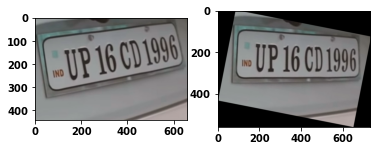

In [6]:
from typing import Tuple, Union
from matplotlib import pyplot as plt
import numpy as np
import cv2
import math
from deskew import determine_skew

def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

image = cv2.imread('images/1.jpg')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
rotated = rotate(image, angle, (0, 0, 0))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(rotated)
plt.show()

# Homograpy using Automatic Perspective Transform

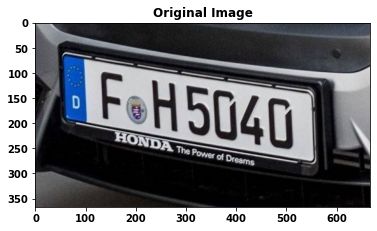

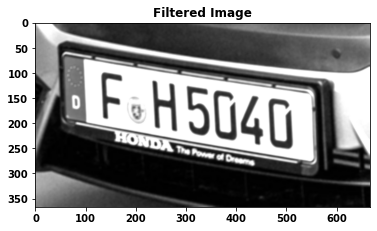

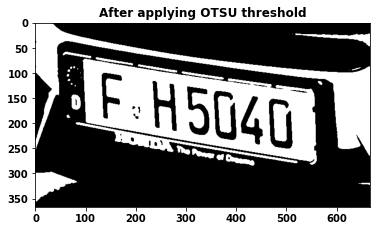

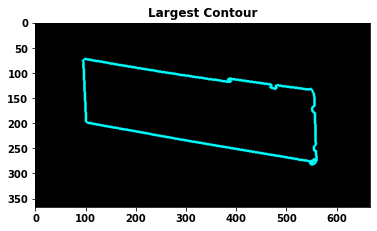


The corner points are ...

A : [95, 76]
B : [103, 199]
C : [549, 132]
D : [560, 275]


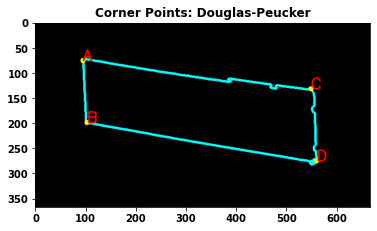


The destination points are: 

A' : [0. 0.]
B' : [462.   0.]
C' : [  0. 142.]
D' : [462. 142.]

The approximated height and width of the original image is: 
 (143, 463)

The homography matrix is: 
 [[ 1.23186504e+00 -8.01213036e-02 -1.10937960e+02]
 [-1.49052458e-01  1.20838957e+00 -7.76776240e+01]
 [ 3.64928311e-04  3.61159114e-06  1.00000000e+00]]


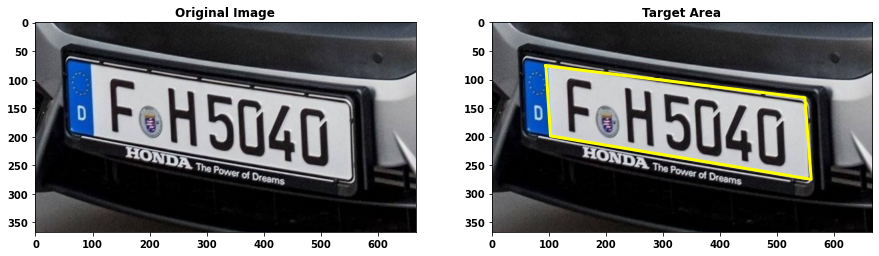

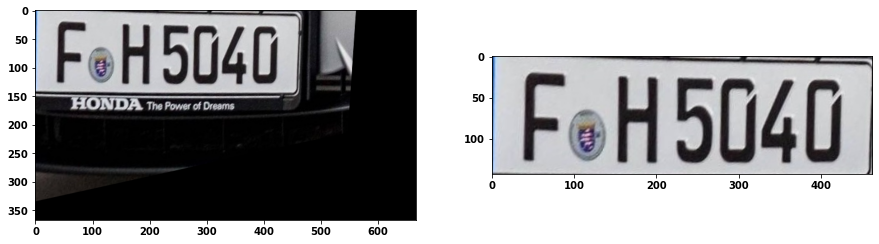

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shi_tomashi(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print('\nThe corner points are...\n')

    im = image.copy()
    for index, c in enumerate(corners):
        x, y = c
        cv2.circle(im, (x, y), 3, 255, -1)
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(im, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

    plt.imshow(im)
    plt.title('Corner Detection: Shi-Tomashi')
    plt.show()
    return corners


def get_destination_points(corners):
    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])

    print('\nThe destination points are: \n')
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)

    print('\nThe approximated height and width of the original image is: \n', (h, w))
    return destination_corners, h, w


def unwarp(img, src, dst):
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    print('\nThe homography matrix is: \n', H)
    un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.imshow(img)
    ax1.set_title('Original Image')

    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

    ax2.imshow(img)
    ax2.plot(x, y, color='yellow', linewidth=3)
    ax2.set_ylim([h, 0])
    ax2.set_xlim([0, w])
    ax2.set_title('Target Area')
    plt.show()
    return un_warped


def apply_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5, 5), np.float32) / 15
    filtered = cv2.filter2D(gray, -1, kernel)
    plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
    plt.title('Filtered Image')
    plt.show()
    return filtered

def apply_threshold(filtered):
    ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_OTSU)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.title('After applying OTSU threshold')
    plt.show()
    return thresh

def detect_contour(img, image_shape):
    canvas = np.zeros(image_shape, np.uint8)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    cv2.drawContours(canvas, cnt, -1, (0, 255, 255), 3)
    plt.title('Largest Contour')
    plt.imshow(canvas)
    plt.show()
    return canvas, cnt

def detect_corners_from_contour(canvas, cnt):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
    approx_corners = sorted(np.concatenate(approx_corners).tolist())
    print('\nThe corner points are ...\n')
    for index, c in enumerate(approx_corners):
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(canvas, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]

    plt.imshow(canvas)
    plt.title('Corner Points: Douglas-Peucker')
    plt.show()
    return approx_corners

def example_two():
    image = cv2.imread('images/frame161.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title('Original Image')
    plt.show()

    filtered_image = apply_filter(image)
    threshold_image = apply_threshold(filtered_image)

    cnv, largest_contour = detect_contour(threshold_image, image.shape)
    corners = detect_corners_from_contour(cnv, largest_contour)

    destination_points, h, w = get_destination_points(corners)
    un_warped = unwarp(image, np.float32(corners), destination_points)

    cropped = un_warped[0:h, 0:w]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.imshow(un_warped)
    ax2.imshow(cropped)
    plt.show()


if __name__ == '__main__':
#     example_one()
    example_two()

In [79]:
Rotating Images using Moviepy Library

In [5]:
from moviepy.editor import *

clip = ImageClip('images/1.jpg',fromalpha=3)
rotated_clip = (clip.add_mask()
                .fx(vfx.resize, width=30, height=300)
                .fx(vfx.rotate, lambda t: 30*t, expand=False)
                .set_duration(5))
final_clip = CompositeVideoClip([rotated_clip.set_pos("center")], size=(800,800), bg_color=3*[255],  )
final_clip.write_videofile("test.mp4", fps=25, codec="libx264")

t:   0%|                                                                             | 0/125 [00:00<?, ?it/s, now=None]

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [92]:
from moviepy.editor import VideoFileClip, vfx
video = VideoFileClip('images/1.jpg')
out = video.fx(vfx.mirror_x)
out.write_videofile('out.mp4')

Moviepy - Building video out.mp4.
Moviepy - Writing video out.mp4

Moviepy - Done !
Moviepy - video ready out.mp4
